<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [108]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings


# importar funciones de soporte
# -----------------------------------------------------------------------
from src import soporte_preprocesamiento as sup_prep
from src import soporte_nulos as sup_nul

##aplicar configuraciones
#------------------------------------------------------------------------
warnings.filterwarnings('ignore')
pd.set_option('display.max_info_columns', 50)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) #eliminamos la notacion cientifica

tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
df = pd.read_csv('datos/financial_data.csv')
df.sample(2)

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
9892,9893,1049,2005,396.14,2023-01-01 02:44:52,1,MasterCard,City-8,Gas Station,20,Purchase at Merchant-2005
8266,8267,1039,2066,9402.25,2023-01-01 02:17:46,0,Visa,City-16,Travel,41,Purchase at Merchant-2066


### Exploracion Inicial

In [110]:
sup_prep.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 11

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
customer_id,10000.00,1051.27,28.86,1001.00,1026.00,1052.00,1076.00,1100.00
merchant_id,10000.00,2050.49,28.88,2001.00,2025.00,2050.00,2076.00,2100.00
amount,10000.00,4958.38,2899.70,10.61,2438.18,4943.94,7499.31,9999.75
is_fraudulent,10000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
customer_age,10000.00,44.05,15.32,18.00,31.00,44.00,57.00,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 00:00:00,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Los columnas con valores nulos y sus porcentajes son: 


,%_nulos



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


None

## Convertimos la variable ```transaction_time``` a un tipo adecuado.

In [111]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df.sample()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
4183,4184,1011,2099,1960.37,2023-01-01 01:09:43,0,American Express,City-24,Groceries,38,Purchase at Merchant-2099


In [112]:
print(f"Fecha mas antigua: {df['transaction_time'].min()}")
print(f"Fecha mas reciente: {df['transaction_time'].max()}")

Fecha mas antigua: 2023-01-01 00:00:00
Fecha mas reciente: 2023-01-01 02:46:39


### (vemos que los registros van desde las 00 hasta las 02:56:39. Todo la misma noche)

## Acontinuación visualizaremos las variables de nuestro dataframe, y para esto omitiremos algunas varibales como los id

In [113]:
vis = sup_prep.Visualizador(df.drop(columns=['transaction_id', 'transaction_time']))

## Ploteamos las variables numericas y categoricas

5it [00:00,  5.16it/s]


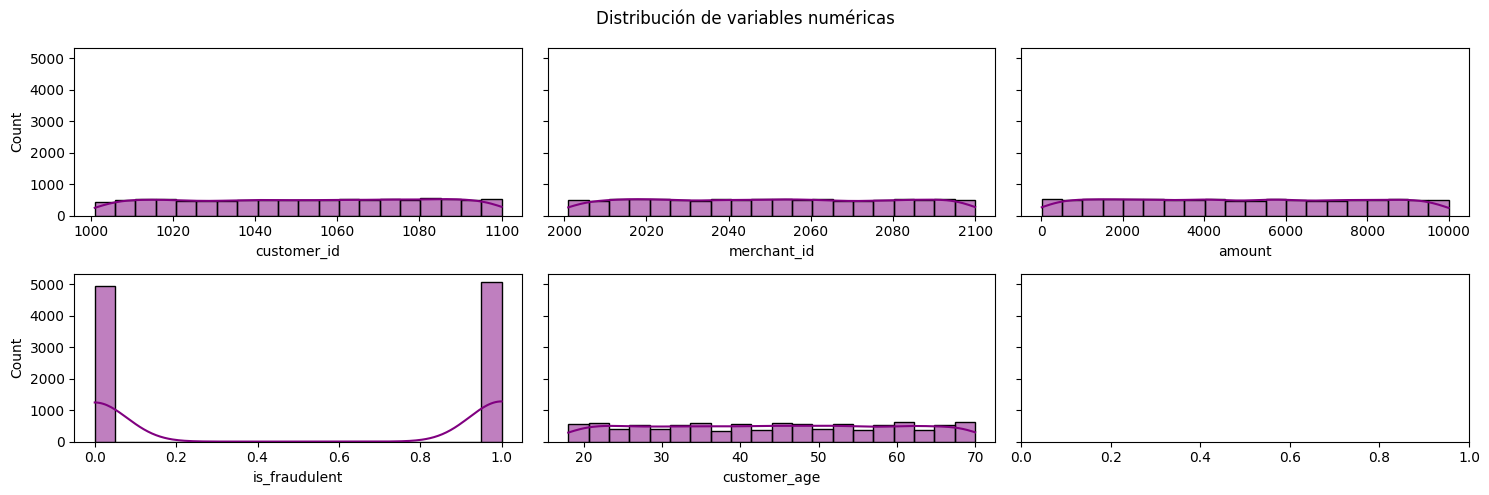

In [114]:
vis.plot_numericas(color='purple', kde=True)

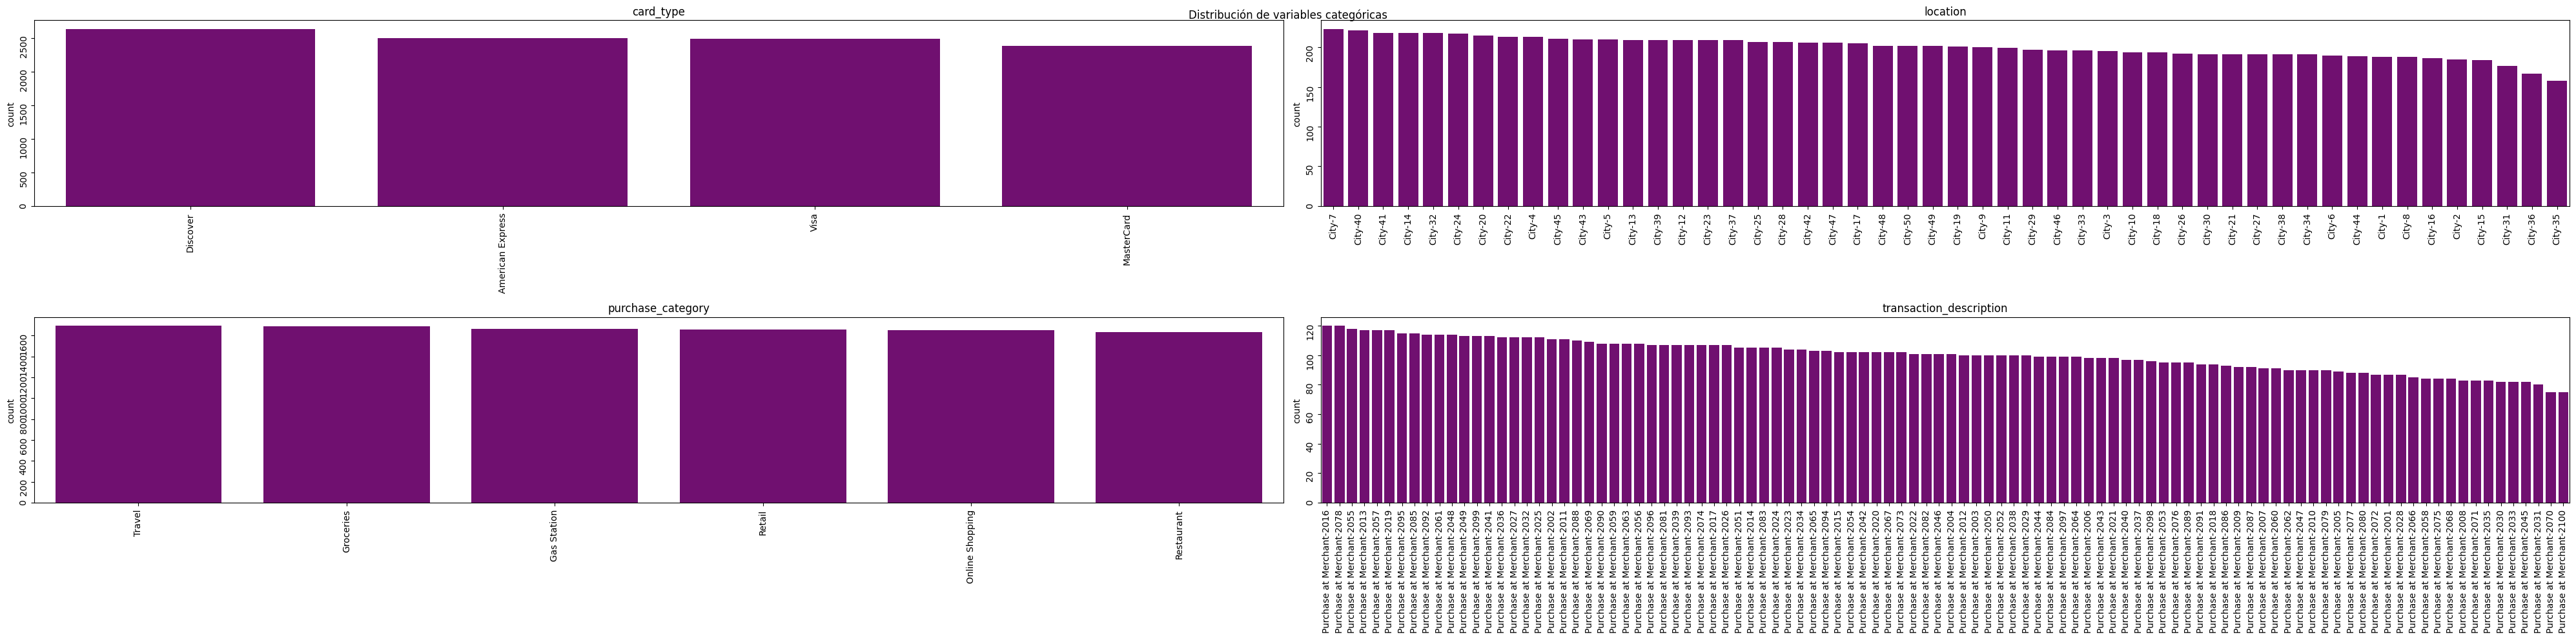

In [115]:
vis.plot_categoricas(color='purple')

## Vemos si hay relación entre las variables.

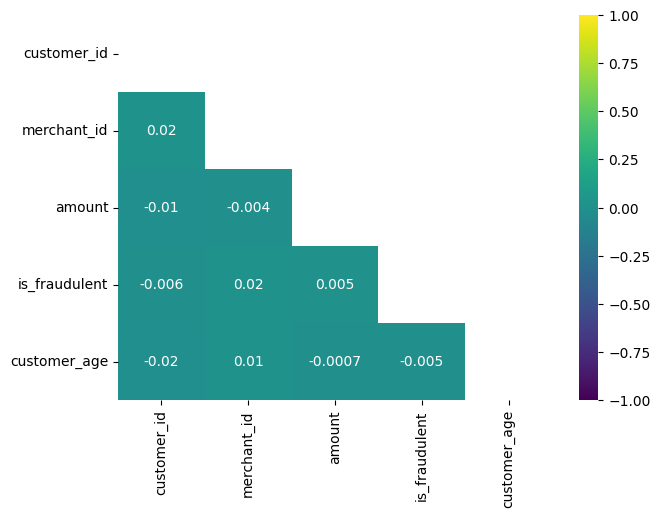

In [116]:
vis.correlacion()

### (no hay relación entre las variables a priori)

### Vemos como se relaciona la variable ```is_fraudulent``` con las demás.

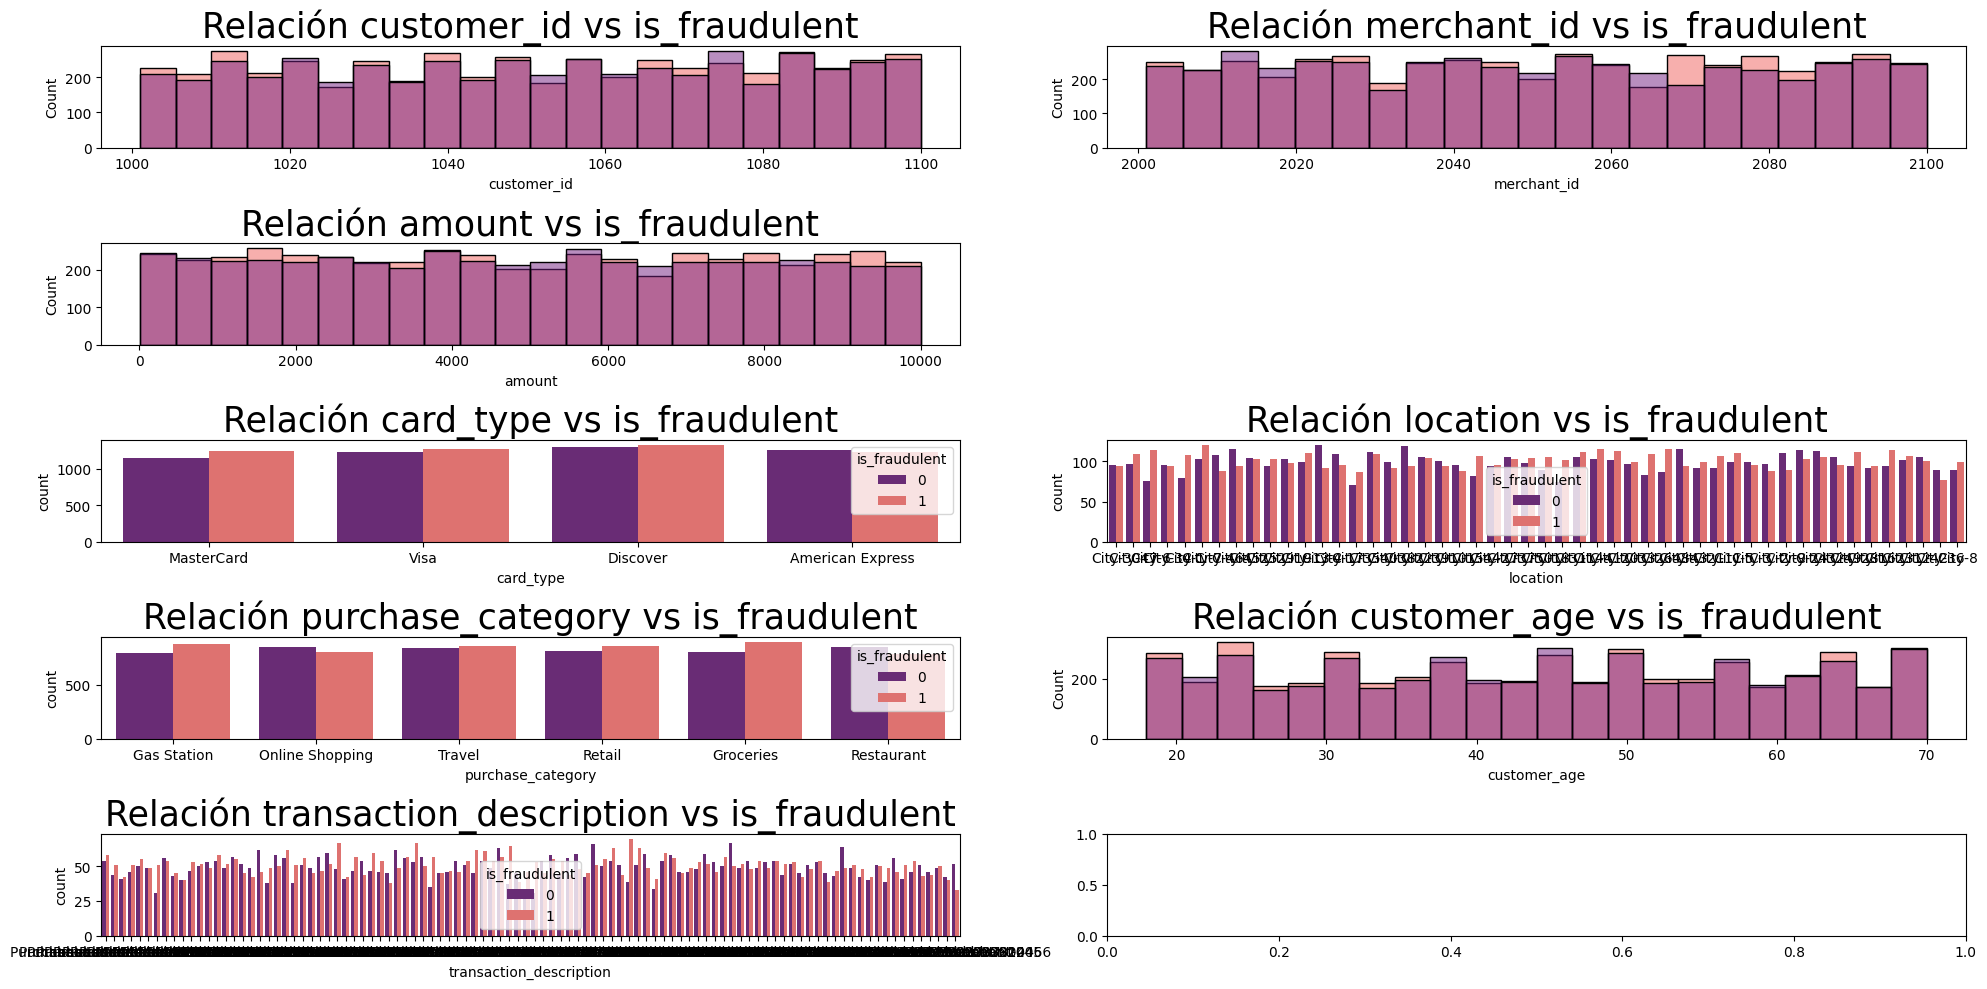

In [117]:
vis.plot_relacion(vr='is_fraudulent')

### (posteriormente realizaremos unas pruebas para ver si hay diferencias entre las variables)

## Hacemos algunas agrupaciones

In [118]:
pd.DataFrame(df.groupby('card_type')['is_fraudulent'].count()).sort_values(by='is_fraudulent', ascending=False)

,is_fraudulent
card_type,
Discover,2633
American Express,2494
Visa,2490
MasterCard,2383


(podemos ver que hay un poco más de transacciones fraudulentas con el tipo de tarjeta 'Discover')

In [119]:
len(df['customer_id'].unique())

100

(estos serían los 10 clientes que han realizado más transacciones)

In [120]:
df['customer_id'].value_counts()[:10]

customer_id
1074    126
1085    120
1059    118
1018    116
1099    116
1079    115
1061    115
1039    115
1089    115
1012    114
Name: count, dtype: int64

(esto son los 10 clientes que mas dinero han movido)

In [121]:
df.groupby('customer_id')['amount'].sum().reset_index().sort_values(by='amount', ascending=False).head(10)

,customer_id,amount
73,1074,634349.05
84,1085,619231.16
11,1012,617206.86
88,1089,599948.93
40,1041,598831.69
58,1059,597598.55
60,1061,595567.08
17,1018,590880.37
86,1087,578953.92
38,1039,578364.21


(vemos los merch_id que mas dinero han movido tambien)

In [122]:
df.groupby('merchant_id')['amount'].sum().reset_index().sort_values(by='amount', ascending=False).head(10)

,merchant_id,amount
77,2078,658550.65
15,2016,597887.55
56,2057,595346.22
60,2061,595004.52
94,2095,594506.53
84,2085,589981.42
98,2099,581608.46
18,2019,578712.75
47,2048,577587.14
10,2011,574222.77


## Vamos a quitarnos las variables que no nos aportan información para nuestro estudio.

In [123]:
df.sample()

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
5577,5578,1059,2094,3888.79,2023-01-01 01:32:57,1,American Express,City-43,Travel,53,Purchase at Merchant-2094


In [124]:
df['transaction_id'].duplicated().sum()

0

- (viendo que no tenemos transaction_id repetidos, por lo que nos la quitaremos)
- (transaction_time por el momento lo vamos a quitar, pero lo utilizaremos en otro estudio posterior)
- transaction_description lo quitamos tambien ya que si quitamos el texto (Purchase at Merchant-), vemos que nos aporta el mismo valor que merchant_id.

In [125]:
df.drop(columns=['transaction_id', 'transaction_time', 'transaction_description'], inplace=True)

---
---

## Miramos si existen diferencias entre nuestras variables categoricas.

In [126]:
sup_prep.detectar_orden_cat_bina(df, df.select_dtypes('O'), var_respuesta='is_fraudulent')

Estamos evaluando la variable CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


Para la categoría CARD_TYPE NO hay diferencias significativas, p = 0.2861

--------------------------------------------------------------------------------
Estamos evaluando la variable LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


Para la categoría LOCATION NO hay diferencias significativas, p = 0.1815

--------------------------------------------------------------------------------
Estamos evaluando la variable PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


Para la categoría PURCHASE_CATEGORY SÍ hay diferencias significativas, p = 0.0208


is_fraudulent,0,1
purchase_category,,
Gas Station,822.00,844.00
Groceries,834.00,858.00
Online Shopping,814.00,837.00
Restaurant,807.00,829.00
Retail,819.00,842.00
Travel,835.00,859.00


--------------------------------------------------------------------------------


---
---

## Encoding

In [127]:
df.reset_index(drop=True, inplace=True)

In [128]:
df.sample()

,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age
3694,1094,2019,2519.77,1,American Express,City-26,Restaurant,39


In [129]:
df_pre_modelo = df.copy()

In [130]:
df_pre_modelo.sample()

,customer_id,merchant_id,amount,is_fraudulent,card_type,location,purchase_category,customer_age
2575,1066,2019,4525.54,1,American Express,City-47,Gas Station,42


In [131]:
onehot = OneHotEncoder()
trans_one_hot = onehot.fit_transform(df_pre_modelo[['card_type', 'location']])
df_one_hot = pd.DataFrame(trans_one_hot.toarray(), columns=onehot.get_feature_names_out())

In [132]:
target_encoder = TargetEncoder()
target_encoded_cols = target_encoder.fit_transform(df_pre_modelo[['purchase_category']], df_pre_modelo['is_fraudulent']) 

In [133]:
target_encoded_cols.sample()

,purchase_category
446,0.48


In [149]:
df_encoded = pd.concat([df_pre_modelo['is_fraudulent'], df_one_hot, target_encoded_cols], axis=1)
df_encoded['customer_age'] = df_pre_modelo['customer_age']

---
---

## Feature Scaling

In [150]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded.drop(columns=['is_fraudulent'])),
                         columns=df_encoded.drop(columns=['is_fraudulent']).columns)

In [151]:
df_scaled.columns

Index(['card_type_American Express', 'card_type_Discover',
       'card_type_MasterCard', 'card_type_Visa', 'location_City-1',
       'location_City-10', 'location_City-11', 'location_City-12',
       'location_City-13', 'location_City-14', 'location_City-15',
       'location_City-16', 'location_City-17', 'location_City-18',
       'location_City-19', 'location_City-2', 'location_City-20',
       'location_City-21', 'location_City-22', 'location_City-23',
       'location_City-24', 'location_City-25', 'location_City-26',
       'location_City-27', 'location_City-28', 'location_City-29',
       'location_City-3', 'location_City-30', 'location_City-31',
       'location_City-32', 'location_City-33', 'location_City-34',
       'location_City-35', 'location_City-36', 'location_City-37',
       'location_City-38', 'location_City-39', 'location_City-4',
       'location_City-40', 'location_City-41', 'location_City-42',
       'location_City-43', 'location_City-44', 'location_City-45',
     

In [152]:
df_scaled = pd.concat([df_pre_modelo['is_fraudulent'], df_scaled], axis=1)

In [153]:
df_scaled.head()

,is_fraudulent,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa,location_City-1,location_City-10,location_City-11,location_City-12,location_City-13,location_City-14,location_City-15,location_City-16,location_City-17,location_City-18,location_City-19,location_City-2,location_City-20,location_City-21,location_City-22,location_City-23,location_City-24,location_City-25,location_City-26,location_City-27,location_City-28,location_City-29,location_City-3,location_City-30,location_City-31,location_City-32,location_City-33,location_City-34,location_City-35,location_City-36,location_City-37,location_City-38,location_City-39,location_City-4,location_City-40,location_City-41,location_City-42,location_City-43,location_City-44,location_City-45,location_City-46,location_City-47,location_City-48,location_City-49,location_City-5,location_City-50,location_City-6,location_City-7,location_City-8,location_City-9,purchase_category,customer_age
0,0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.90,0.48
1,1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.83
2,1,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.90,0.75
3,1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.51,0.79
4,1,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.68,0.35


## Como hemos visto arriba en los boxplot que no tenemos outlayers, no los voy a mirar. Posteriormente puede que se haga en caso de querer afinar el modelo.

---
---

## Salvamos los datos.

In [154]:
df_scaled.to_pickle('datos/encoded_financial_data.pkl')